<a href="https://colab.research.google.com/github/rohitxo07/GEN-AI/blob/main/Copy_of_Gen_AI_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 127.5 - 1  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
latent_dim = 100
batch_size = 128
buffer_size=60000

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*128, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(64, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def train_step(images):
    # Get the current batch size
    current_batch_size = tf.shape(images)[0]
    noise = tf.random.normal([current_batch_size, latent_dim])

    # Real labels = 1, Fake labels = 0
    real_labels = tf.ones((current_batch_size, 1))
    fake_labels = tf.zeros((current_batch_size, 1))

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss_real = cross_entropy(real_labels, real_output)
        disc_loss_fake = cross_entropy(fake_labels, fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

        gen_loss = cross_entropy(real_labels, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return disc_loss, gen_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  # Scale from [-1,1] to [0,1]

    fig = plt.figure(figsize=(5,5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Fixed seed to see progress over epochs
seed = tf.random.normal([25, latent_dim])

Epoch 1, Discriminator Loss: 0.4598, Generator Loss: 1.6362


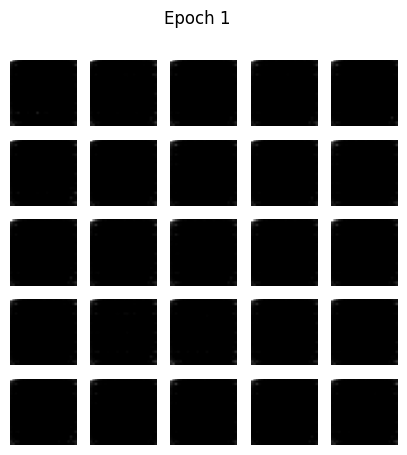

Epoch 2, Discriminator Loss: 1.1813, Generator Loss: 0.9654


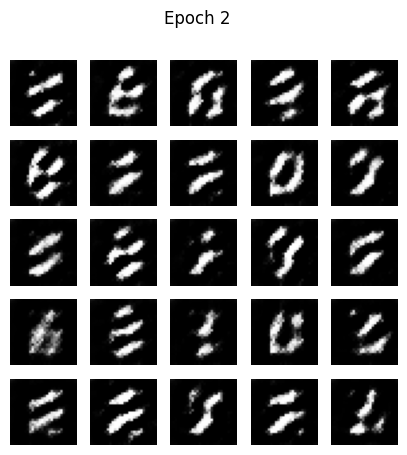

In [ ]:
epochs = 2
for epoch in range(1, epochs+1):
    for image_batch in dataset:
        d_loss, g_loss = train_step(image_batch)

    print(f'Epoch {epoch}, Discriminator Loss: {d_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}')

    # Generate and display images after each epoch
    generate_and_save_images(generator, epoch, seed)